Word2Vec model
=============


The goal of here is to train Word2Vec skip-gram and CBOW models over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
%matplotlib inline
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'

def download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        filename, _ = urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified %s' % filename)
    else:
        print(statinfo.st_size)
        raise Exception(
          'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

filename = download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [81]:
filename = 'text8.zip'
def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words"""
    with zipfile.ZipFile(filename) as f:
        #data = tf.compat.as_str(f.read(f.namelist()[0])).split()
        data = f.read(f.namelist()[0]).decode('utf-8').split()
    return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


In [82]:
words

['anarchism',
 'originated',
 'as',
 'a',
 'term',
 'of',
 'abuse',
 'first',
 'used',
 'against',
 'early',
 'working',
 'class',
 'radicals',
 'including',
 'the',
 'diggers',
 'of',
 'the',
 'english',
 'revolution',
 'and',
 'the',
 'sans',
 'culottes',
 'of',
 'the',
 'french',
 'revolution',
 'whilst',
 'the',
 'term',
 'is',
 'still',
 'used',
 'in',
 'a',
 'pejorative',
 'way',
 'to',
 'describe',
 'any',
 'act',
 'that',
 'used',
 'violent',
 'means',
 'to',
 'destroy',
 'the',
 'organization',
 'of',
 'society',
 'it',
 'has',
 'also',
 'been',
 'taken',
 'up',
 'as',
 'a',
 'positive',
 'label',
 'by',
 'self',
 'defined',
 'anarchists',
 'the',
 'word',
 'anarchism',
 'is',
 'derived',
 'from',
 'the',
 'greek',
 'without',
 'archons',
 'ruler',
 'chief',
 'king',
 'anarchism',
 'as',
 'a',
 'political',
 'philosophy',
 'is',
 'the',
 'belief',
 'that',
 'rulers',
 'are',
 'unnecessary',
 'and',
 'should',
 'be',
 'abolished',
 'although',
 'there',
 'are',
 'differing',
 '

Build the dictionary and replace rare words with UNK token.

In [83]:
# data               ->  [index, ...]
# count              ->  [[word,count],[...]]
# dictionary         ->  {word:index}
# erverse_dictionary ->  {index:word}

vocabulary_size = 50000

def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count = unk_count + 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5243, 3081, 12, 6, 195, 2, 3136, 46, 59, 156]


Function to generate a training batch for the skip-gram model.

In [84]:
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch  = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])


for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['anarchism', 'as', 'a', 'originated', 'term', 'as', 'of', 'a']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['anarchism', 'term', 'originated', 'a', 'of', 'term', 'as', 'originated']


## 1 Skip-Gram model.

In [85]:
data_index     = 0
batch_size     = 200
embedding_size = 128    # Dimension of the embedding vector (number of neurons).
skip_window    = 5      # How many words to consider left and right.
num_skips      = 10     # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 

valid_size     = 4  # Random set of words to evaluate similarity on.
valid_window   = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled    = 64 # Number of negative examples to sample.

graph = tf.Graph()
with graph.as_default():

    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels  = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
    # hidden weights
    embeddings = tf.Variable(
            tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(
            tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
    # Model.
    # Look up embeddings for inputs.
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

    # Optimizer.
    # Note: The optimizer will optimize the softmax_weights AND the embeddings.
    # This is because the embeddings are defined as a variable quantity and the
    # optimizer's `minimize` method will by default modify all variable quantities 
    # that contribute to the tensor it is passed.
    # See docs on `tf.train.Optimizer.minimize()` for more details.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
        normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [54]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 10000 == 0:
      if step > 0:
        average_loss = average_loss / 10000
      # The average loss is an estimate of the loss over the last 10000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
      # note that this is expensive (~20% slowdown if computed every 500 steps)
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.993428
Nearest to three: disliked, seizures, consciously, saragossa, josef, haydn, consult, emb,
Nearest to only: amir, thoroughbred, newsmagazine, parmenides, tubulin, warrior, hemingway, predator,
Nearest to most: kaohsiung, storyteller, confiscation, guglielmo, scribner, torr, rising, reconstructionism,
Nearest to an: pron, waley, threaten, delay, prepositions, affectionate, overwriting, peasants,
Nearest to d: maths, associated, rumored, homotopy, entrepreneurship, trafalgar, perp, simulator,
Nearest to are: inferior, domino, eminently, deport, dion, predominance, alfred, tier,
Nearest to by: belgrano, vice, ticker, bets, casings, jtc, contrastive, chevron,
Nearest to nine: madge, relaunched, commits, defections, contrasted, substrates, storybook, mont,
Nearest to during: commentators, borland, lot, purple, plantinga, shabazz, nter, privatisation,
Nearest to from: transformer, calista, ott, acadians, greeks, techniques, cisneros, inexplicable,


Average loss at step 70000: 3.875262
Nearest to three: four, seven, five, six, eight, two, zero, one,
Nearest to only: when, so, but, although, not, however, before, it,
Nearest to most: some, more, many, these, lugh, michelob, other, history,
Nearest to an: a, this, which, its, businessweek, it, example, another,
Nearest to d: b, creighton, h, c, r, madhava, yule, v,
Nearest to are: were, these, have, some, many, other, them, poodle,
Nearest to by: which, stimulate, and, that, has, this, with, however,
Nearest to nine: seven, six, eight, one, four, three, five, zero,
Nearest to during: after, war, gabrielle, world, second, khwarizmi, first, khanate,
Nearest to from: into, through, deviate, bungalow, goitre, in, blas, around,
Nearest to first: inker, six, chocolat, overwhelm, during, unresponsive, second, third,
Nearest to s: forall, postpositions, national, nine, whey, u, service, pollute,
Nearest to used: suitor, use, reprinting, known, couples, bodkin, ach, iy,
Nearest to on: throug

In [117]:
def eval_context(positive=[],negative=[]):
    vec = np.zeros(embedding_size)
    for word in positive:
        vec = vec + final_embeddings[dictionary[word],:]
        vec=vec/ np.sqrt(np.sum(vec**2))
    for word in negative:
        vec = vec - final_embeddings[dictionary[word],:]
        vec=vec/ np.sqrt(np.sum(vec**2))
    sim = np.dot(vec, final_embeddings.T)
    nearest = (-sim).argsort()[1:9]
    words = []
    for k in range(8):
          words.append(reverse_dictionary[nearest[k]])
    return list(zip(words,sim[nearest]))

In [118]:
eval_context(positive=['war'])

[('during', 0.5510961311028284),
 ('ii', 0.42071914704531432),
 ('world', 0.41332876059920276),
 ('averaged', 0.36568018997593399),
 ('rag', 0.36362524316523281),
 ('resettle', 0.3561786895708855),
 ('kambojas', 0.34471920956710461),
 ('period', 0.33623311610942608)]

In [72]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

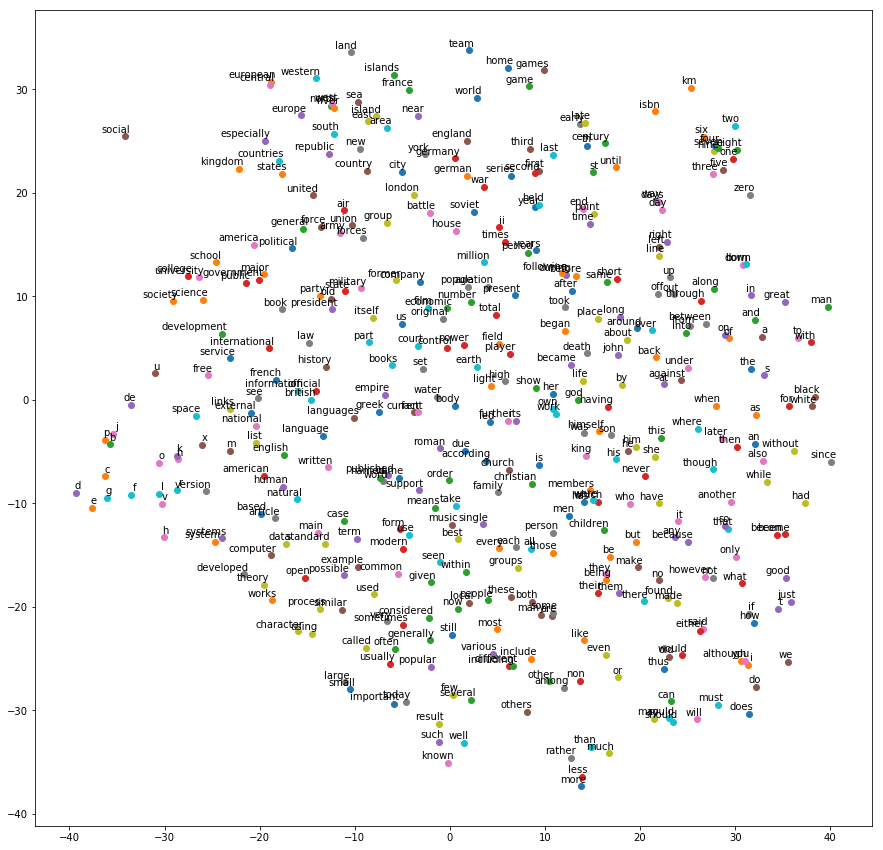

In [73]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

2. CBOW model
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. 

In [127]:
def generate_batch_cbow(batch_size, skip_window):
    global data_index
    context_window = 2 * skip_window # calculate the context_window - this is the total number of words around the target
    assert batch_size % context_window == 0 # ensure the context window can be taken from the batch size
    num_labels = batch_size // context_window # the number of labels is the how many context windows fit in the batch
    batch  = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(num_labels, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(num_labels):
        target = skip_window  # target label at the center of the buffer
        labels[i, 0] = buffer[target] # set the label
        targets_to_avoid = [ skip_window ]
        for j in range(context_window):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * context_window + j] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels


data_index = 0
skip_window = 2
batch_size  = 12
batch, labels = generate_batch_cbow(batch_size, skip_window)
for i in range(batch_size):
    print(reverse_dictionary[batch[i]], '->', reverse_dictionary[labels[i//(2*skip_window), 0]])
del skip_window # remove skip_window setting used for testing

a -> as
term -> as
originated -> as
anarchism -> as
term -> a
of -> a
originated -> a
as -> a
of -> term
a -> term
abuse -> term
as -> term


In [151]:
data_index     = 0
batch_size     = 500
embedding_size = 128    # Dimension of the embedding vector (number of neurons).
skip_window    = 5      # How many words to consider left and right.
num_labels     = batch_size//(2*skip_window)


seq_ids = np.zeros(batch_size, dtype=np.int32)
cur_id = -1
for i in range(batch_size):
    if i % (2*skip_window) == 0:
        cur_id = cur_id + 1
    seq_ids[i] = cur_id


# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 

num_sampled    = 32 # Number of negative examples to sample.

# graph = tf.Graph()
# with graph.as_default():

# Input data.
train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
train_labels  = tf.placeholder(tf.int32, shape=[num_labels, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

# hidden weights
embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))    
softmax_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                     stddev=1.0 / math.sqrt(embedding_size)))
softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

# Model.
# Look up embeddings for inputs & average.
embed = tf.segment_sum(tf.nn.embedding_lookup(embeddings, train_dataset),seq_ids)


# Compute the softmax loss, using a sample of the negative labels each time.
loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                           labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

# Compute the similarity between minibatch examples and all embeddings.
# We use the cosine distance:
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
normalized_embeddings = embeddings / norm


In [152]:
num_steps = 500001

session = tf.Session()
tf.global_variables_initializer().run(session=session)
average_loss = 0
for step in range(num_steps):
    batch_data, batch_labels = generate_batch_cbow(batch_size, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 5000 == 0:
        if step > 0:
            average_loss = average_loss / 5000
        print("Average loss at step", step, ":", average_loss)
        average_loss = 0
    

Average loss at step 0 : 9.0634765625
Average loss at step 5000 : 43.6549202086
Average loss at step 10000 : 36.4847005766
Average loss at step 15000 : 32.2446894029
Average loss at step 20000 : 27.5805363232
Average loss at step 25000 : 27.9623963609
Average loss at step 30000 : 26.7376496603
Average loss at step 35000 : 25.4999741983
Average loss at step 40000 : 24.5331876771
Average loss at step 45000 : 23.1756706004
Average loss at step 50000 : 23.0354888339
Average loss at step 55000 : 21.6192554681
Average loss at step 60000 : 21.9234630781
Average loss at step 65000 : 21.2029702974
Average loss at step 70000 : 19.1830818341
Average loss at step 75000 : 20.3374310742
Average loss at step 80000 : 19.7221555227
Average loss at step 85000 : 19.2991312072
Average loss at step 90000 : 19.3099959707
Average loss at step 95000 : 18.9009855179
Average loss at step 100000 : 18.130471362
Average loss at step 105000 : 17.5301969588
Average loss at step 110000 : 17.1916984815
Average loss at